<img src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="200"/>

# Getting Started with the Arize Platform - Click-Through Rate in the Advertisement Industry

**In this walkthrough, we are going to investigate various performance related aspects of an online advertisement use-case. More specificlly we will be using the Arize platform to monitor Click-through Rate (CTR) performance.**

You manage the Machine Learning models for an online adveristing platform. You have spent a great deal of your time collecting online data and traning models for best performance. With your models now in production you have no tools available to your disposal to monitor the performance of your models, identify any issues or get insights into how to improve your models. In this walkthrough we will look at a few scenarios common to an adverstisement use-case and more specifically looking at CTR predictions versus actuals for a given ad or ad group.

You will learn to:

1. Get training, valdiation, and production data into the Arize platform
2. Setup performance dashboards
3. Setup threshold alerts
4. Understand where the model is underperforming
5. Discover the root cause of issues

The sample data contains 1 month of information in which 3 main characteristics exist. You will work on identifying these characteristics in the course of this exercise. At a glance:

1. A new untrained domain is introduced
2. Bad data is received in one of the feature
3. The model is inacurate during some time period

---

**Assumptions**: A typical CTR can be as low as only a few percents or less meaning that user clicks are very sparse relative to the total number of impressions. In this example we use a relatively high CTR of about 6.5% with a relatively small dataset. By definition the CTR of an ad or ad group can be expressed as:

$$CTR = \frac{Clicks}{Impressions}$$

A CTR model predicts probabilities of an impression getting a click. The actual score for the impression can be represented as 0 or 1 with 1 meaning the impression received a click. For example:

Predicted Probability (Score)  | Outcome     | Actual Score
-----------------------|---------------------|------------------
0.05                   | User did not click  | 0
0.15                   | User clicked        | 1
0.02                   | User did not click  | 0


As seen in this table we a must be able to compare probabilities (0 to 1) with discrete (0 or 1) scores in order to evaluate the performance of a CTR model. In this exercise we will be using a log-loss function as a classification metric. Log-loss tracks how close the prediction probability is to the corresponding actual score (0 or 1) and penalises based on how far the prediction is. The more the predicted probability diverges from the actual score, the higher is the log-loss value.

---






# Step 0. Setup and Getting the Data
First step is to load a preexisting dataset that represents a Click-through Rate use-case including training, validation, and prediction data. Using a preexisting dataset saves time in this example and also illustrates how simple it is to plug into the Arize platform.
## Install Dependencies and Import Libraries 📚

In [ ]:
!pip install -q arize

import datetime
import uuid
from datetime import timedelta

import pandas as pd
from arize.pandas.logger import Client, Schema
from arize.utils.types import Environments, ModelTypes

## **🌐 Download the Data**

In [ ]:
datasets = {}
for environment in ["training", "validation", "production"]:
    datasets[environment] = pd.read_csv(
        f"https://storage.googleapis.com/arize-assets/fixtures/Tags-Demo-Data/click_through_rate_{environment}.csv"
    )

print("✅ Dependencies installed and data successfully downloaded!")

## Inspect the Data
Take a quick look at the dataset. The data represents a model designed and trained to evaluate the probability of a user clicking on an a given ad or ad group based on various features such as domain, page category, position, matching keywords, etc. The dataset containts one month of data and the performance will be evaluated by looking particularly at:

*   **CTR_predicted**: The probability of a click predicted by the model for the ad or ad group (values from 0 to 1, 1 representing 100%)
*   **actuals**: The actual click/noclick value as a string for the impression



In [ ]:
datasets["production"].head()

In [ ]:
features_col_names = [
    "position",
    "domain",
    "category",
    "device",
    "keywords",
]
shap_col_names = [f"{x}_shap" for x in features_col_names]
tag_column_names = ['Dependents', 'Partner', 'EmploymentStatus', 'LocationCode', 'Education', 'State', 'Gender', 'Age']

# Step 1. Sending Data into Arize 💫

Now that we have our data configured, we are ready to integrate into Arize. We do this by logging (sending) important data we want to analyze to the platform. There, the data will be easily visualized and investigated to source our problem.

For our model, we are going to log:

*   feature data
*   predictions
*   actuals

## Import and Setup Arize Client

The first step is to setup our Arize client. After that we will log the data.

First, use your Arize account credentials to log in. Thereafter, retrieve the Arize `API_KEY` and `SPACE_KEY` from your admin page shown below! Copy those over to the set-up section. We will also be setting up some metadata to use across all logging.




<img src="https://storage.googleapis.com/arize-assets/fixtures/copy-keys.png" width="700">

In [ ]:
SPACE_KEY = "SPACE_KEY"
API_KEY = "API_KEY"
arize_client = Client(space_key=SPACE_KEY, api_key=API_KEY)

model_id = (
    "click-through-rate-demo-model"  # This is the model name that will show up in Arize
)
model_version = "v1.0"  # Version of model - can be any string

if SPACE_KEY == "SPACE_KEY" or API_KEY == "API_KEY":
    raise ValueError("❌ YOU NEED TO CHANGE SPACE AND/OR API_KEY")
else:
    print("✅ Arize setup complete!")

## Log Training & Validation Data
Now that our Arize client is setup, let's go ahead and log all of our data to the platform. For more details on how **`arize.pandas.logger`** works, visit out documentations page below.

[![Buttons_OpenOrange.png](https://storage.googleapis.com/arize-assets/fixtures/Buttons_OpenOrange.png)](https://docs.arize.com/arize/sdks-and-integrations/python-sdk/arize.pandas)

Key parameters:

*   **prediction_label_column_name**: tells Arize which column contains the predictions ("click"/"noclick")
*  **prediction_score_column_name**: tells Arize which column contains the predicted click rate for the impression (probability 0 to 1)
*   **actual_label_column_name**: tells Arize which column contains the actual results from field data ("click"/"noclick")
*  **actual_score_column_name** same as label but expresed as 0 or 1

We will use [ModelTypes.SCORE_CATEGORICAL](https://docs.arize.com/arize/product-guides-1/models/model-types) to perform this analysis.






In [ ]:
# This is the data which we will be logging
df_train = datasets["training"]
df_valid = datasets["validation"]
df_prod = datasets["production"]


# Define a Schema() object for Arize to pick up data from the correct columns for logging
schema = Schema(
    prediction_id_column_name="prediction_ids",
    prediction_label_column_name="prediction_labels",
    prediction_score_column_name="prediction_scores",
    actual_label_column_name="actuals",
    actual_score_column_name="actual_scores",
    feature_column_names=features_col_names,
    tag_column_names = tag_column_names,
)

# Logging Training DataFrame
response = arize_client.log(
    dataframe=df_train,
    model_id=model_id,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    environment=Environments.TRAINING,
    schema=schema,
)

# If successful, the server will return a status_code of 200
if response.status_code != 200:
    print(f"logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged training set to Arize")

# Logging Validation DataFrame
response = arize_client.log(
    dataframe=df_valid,
    model_id=model_id,
    model_version=model_version,
    batch_id="validation",
    model_type=ModelTypes.SCORE_CATEGORICAL,
    environment=Environments.VALIDATION,
    schema=schema,
)

# If successful, the server will return a status_code of 200
if response.status_code != 200:
    print(f"logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged validation set to Arize")

## Log the Production Data
Similarly, we will use the `arize.pandas.logger` to log the production dataset. Here, we will first need to update the timestamps to align with current day and time. This is to ensure that the sample data shows up as recent in Arize.


In [ ]:
# Adjusting dates for ease of visualization
END_DATE = datetime.date.today().strftime("%Y-%m-%d")
START_DATE = (datetime.date.today() - timedelta(31)).strftime("%Y-%m-%d")


def setPredictionIDandTime(df, start, end):
    out_df = pd.DataFrame()
    dts = pd.date_range(start, end).to_pydatetime().tolist()
    for dt in dts:
        day_df = df.loc[df["day"] == dt.day].copy()
        day_df["prediction_ts"] = int(dt.strftime("%s"))
        out_df = pd.concat([out_df, day_df], ignore_index=True)
    out_df["prediction_ids"] = [str(uuid.uuid4()) for _ in range(out_df.shape[0])]
    return out_df.drop(columns="day")


df_prod = setPredictionIDandTime(df_prod, START_DATE, END_DATE)


# Define a Schema() object for Arize to pick up data from the correct columns for logging
schema = Schema(
    prediction_id_column_name="prediction_ids",
    timestamp_column_name="prediction_ts",
    prediction_label_column_name="prediction_labels",
    prediction_score_column_name="prediction_scores",
    actual_label_column_name="actuals",
    actual_score_column_name="actual_scores",
    feature_column_names=features_col_names,
    shap_values_column_names=dict(zip(features_col_names, shap_col_names)),
    tag_column_names = tag_column_names,
)

# arize_client.log returns a Response object from Python's requests module
response = arize_client.log(
    dataframe=df_prod,
    model_id=model_id,
    model_version=model_version,
    model_type=ModelTypes.SCORE_CATEGORICAL,
    environment=Environments.PRODUCTION,
    schema=schema,
)

# If successful, the server will return a status_code of 200
if response.status_code != 200:
    print(f"logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged production set to Arize")

# Step 2. Confirm Data in Arize ✅
Note that the Arize performs takes about 10 minutes to index the data. While the model should appear immediately, the data will not show up untill the indexing is done. Feel free to head over to the **Data Ingestion** tab for your model to watch Arize works its magic!🔮

**⚠️ DON'T SKIP:**
In order to move on to the next step, make sure your actuals and training/validation sets are loaded into the platform. To check:
1. Naviate to models from the left bar, locate and click on model **arize-demo-click-through-rate**
2. On the **Overview Tab** and make sure you see the actuals as shown below.
3. Actual data will show up under **Model Health**. Once the number changes from **0 Actuals** to **Actuals** (with summary statistics such as cardinality listed in the tables), your production actuals will have been fully recorded on Arize!
4. Verify the list of features under **Model Health**. 

![image](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_model.png)





## Step 3. Set up Model Baseline & Managed Monitors
Now that our data has been logged into the [Arize platform](https://app.arize.com/) we can begin our investigation into our poorly performing CTR model. 

Arize will guide you through setting up a **Baseline** (reference environment for comparison) and automatically create **Monitors** for your model in just a few clicks —just follow the blue banner at the top of the page titled "Finish setting up your model". 

![image.png](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_setup.gif)

Arize can automatically configure monitors that are best suited to your data. From the banner at the top of the screen, select the following configurations after clicking the 'Set up Model' button: 

1. Datasets: `Training Version 1.0`
2. Default Metric: `Accuracy`, Trigger Alert When: `Accuracy is below .7`, Positive Class: `click`
3. Turn On Monitoring: Drift ✅, Data Quality ✅, Performance ✅ 

You will now see that the baseline has been set and **Drift**, **Data Quality**, and **Performance** monitors have been created!!! 

## Step 4. Setting up proactive custom monitors

![image.png](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_monitor.gif)

## Step 5. Exploring Drift

**INFO**: Prediction Drift Impact can surface when drift has impacted your model. Drift (PSI) is a measurement of how much your distribution has drifted. Lastly, Feature Importance helps your explain why even small Drift (PSI) can have significant Drift Impact.


Select the **Drift** tab where model drift is visualized across the selected time period. You will notice that the model experienced a noticeable spike in drift so let's look into it!

You can select a period in time on the graph and you will see the prediction distributions adjust accordingly below the graph. Predicted `click` has increased compared to our baseline as well as there's much less predicted `no_click`.

![image.png](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_pred_drift.gif)

Scroll down further in the page and you will find features of the model listed in order of their prediction drift impact score; the higher score means it contributed more to the model drift. This score is a weighted system that Arize calculates using SHAP values and the feature drift so that you don't need to serach for the top features that are causing drift.

![image.png](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_domain_drift.gif)

## Step 6. Data Quaity Checks

It’s important to immediately surface data quality issues to identify how your data quality maps to your model’s performance. Utilize data quality monitoring to analyze hard failures in your data quality pipeline, such as missing data or cardinality shifts.

1. Missing / Null values could be an indicator of issues from an upstream data source.
2. Cardinality is checked to ensure there are no spikes / drops in feature values.
![image.png](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_null_values.gif)


## Step 7. Performance Analysis

Once a performance monitor is triggered, navigate to the **Performance** tab to start troubleshooting your model issues and gain an understanding of what caused the degradation. The accuracy (our default performance metric) is plotted over the 30 days and it is overlaid on top of bars which measure the volume of predictions. Our model is doing pretty well but there is a fall in accuracy down to ~0.44 so let's look into what could be driving performance down.

If you scroll down, the **Output Segmentation** section includes a confusion matrix which is useful for our model as it is assigning a class to the prediction.

![image](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_pertab0.png)

Let's scroll down even further to the **Performance Breakdown by Feature**, this section is very useful to uncover low performing cohorts within a feature. Since this model is producing SHAP values for every prediction, Arize is able to use those SHAP values to weight performance within each feature to create a **Performance Impact Score**. By sorting by this score instead of just feature importance or min/max performance, Arize is able to surface to the top, the top features that are attributing to decreased performance.


**You can start by comparing the production to training dataset.** This can help answer questions such as "Were we seeing this problem in training?" or "Does my new / previous model version perform better?". It can also be helpful to compare to other windows of production.

![image](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_perf_tab1.gif)


You will notice that the Type I error (false positive error) has significantly increased. The model is predicting that many more clicks than in actuality. The model is expecting a large amount of users to be clicking on a given ad, when in fact they are not.

Here, you can identify low performing segments. By looking at performance breakdown by feature, you can dig even deeper to see which segment within each feature of the model is underperforming. In this case, we are filtering on `device`=`Tablet`, we observe `domain`=`new_site.com`, which has the highest performance impact, comes to the top.

Some of the immediate insights surfaced from the **Feature Performance Tab** are detailed below. 


1.   When filtered on `device`=`Tablet`: Worst performing `domain` is `new_site.com` 

2.   When filtered on `keywords`=`2`: Worst performing `category` is `shopping` 



Moreover, you can compare the overall production dataset to other windows of production. Here, you can investigate what the production dataset looks like in a low performing segment. 

![image](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_perftab2.gif)




## Step 8. Model Performance Overview

As we continue to check in and improve our model's performance, we want to be able to quickly and efficiently view all our important model metrics in a single pane. In the same way we set up a **Model Performance Dashboard** to view our model's most important metrics in a single configurable layout.

Navigate to the Templates section on the left sidebar and scroll down to click on the **Scored Model**. From there select your model, features you care to investigate, and positive class `click`.


![image](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_dashboard.gif)


In addition to the default widgets Arize sets up for your dashboard, you can configure custom metrics your team cares about. In only a few clicks you can add widgets to provide a single glance view of your model's Accuracy and Log Loss. 

![image](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_metrics.png)



Now from the **Prediction Score vs Actual Score by Day** graph notice the increase in prediction score which we can attribute to the lack of training for domain **new_site.com**. 

![image](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_graph.png)


You can refine your graph by adding a similar plot. This time add these filters:

* Pred Shopping: Use **Aggregation Function** : **Average** with **Average of** set to **Prediction Score** with filter *(feature category = [shopping])*. Also add a filter *(feature domain != [new_site.com])*

By excluding domain **new_site.com** and focusing on category **shopping** we can conclude that the difference in predicted CTR versus actual clicks in the later part of the graph is due to the model not accounting for higher CTR for the shopping pages.


# Step 9. Business Impact

Sometimes, we need metrics other than traditional statistical measures to define model performance. [Business Impact](https://app.gitbook.com/o/-MB4weB2E-qpBe07nmSL/s/-MAlgpMyBRcl2qFZRQ67/c/P7XPzKa9hwZON38u42tR/product-guides/advanced/business-impact) is a way to measure your scored model's payoff at different thresholds (i.e, decision boundary for a scored model). 

Getting your marketing and ad campaigns to target the right populations is key to growing and scaling your business. The difference of a few percentage points in your click-through rate can make huge impacts to your marketing and sales funnels. 

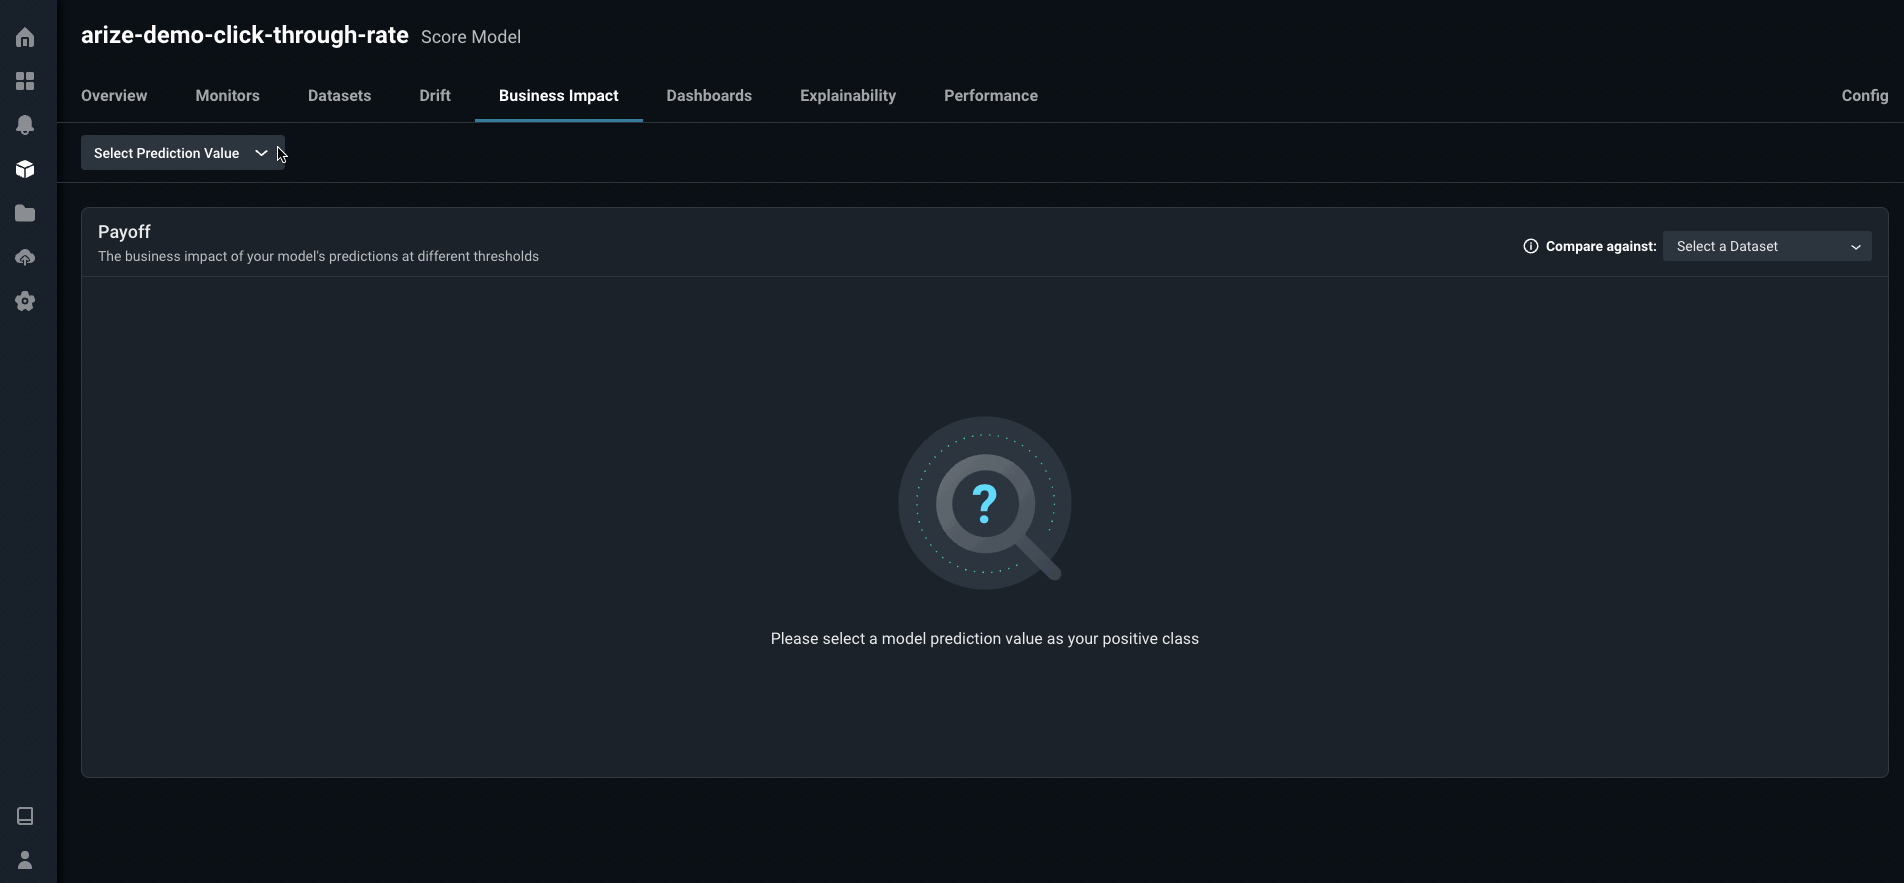

When uses machine learning and building models to detect how well your advertising is performing quantitatively, understanding why your model is behaving the way it is, is more important than ever when it comes to beating the competition. Since models are constantly being exposed to new variables in an ever changing world, it's common that ML and data science professionals will need to be in tune with their models. 


# Step 10. Explainability

Log feature importances to the Arize platform to explain your model's predictions. By logging these values, you gain the ability to view the global feature importances of your predictions as well as the ability to perform global and cohort prediction-based analysis to compare feature importances for your model's features.

![image](https://storage.googleapis.com/arize-assets/fixtures/Click-Through%20Rate%20Use-Case/ctr_explain.png)


# 📚 Conclusion

In this walkthrough we've shown how Arize can be used to log prediction data for a model, pinpoint model performance degredation, and set up monitors to catch future issues. We have been able to identify 3 areas of concern:

1. A new domain appeared in our production system for which the model is untrained for. Re-training to include new_site.com is required.
2. Bogus values are appearing in production. Further investigation is required.
3. The model is pessimistic during parts of the month. The model needs to be re-trained to account for day of the month.

Summary of the analysis and tools:

Concern                   | Detection                       | Root Cause Analysis Tools
--------------------------|---------------------------------|----
Untrained domain or site  | Use a **Drift Monitor**             | - Built-in distribution graphs on each feature<br>- Review distribution at different time intervals
Bad input data            | Use a **Data Quality Monitor**      | - Built-in cardinality graphs<br>- Built-in Empty over Time graph<br>- Create Drift Monitor graph that filters out expected values to focus on bad ones
Inaccuracy                | Use a **Model Performance Monitor** | - Log Loss timeseries widget<br>- Timeseries widget of average prediction score versus Percent (Count/Total) of actual clicks<br>- Filter on features and values to narrow down issues

<br>

Though we covered a lot of ground, this is just scratching the surface of what the Arize platform can do. We urge you to explore more of Arize, either on your own or through one of our many other tutorials.



# About Arize
Arize is an end-to-end ML observability and model monitoring platform. The platform is designed to help ML engineers and data science practitioners surface and fix issues with ML models in production faster with:
- Automated ML monitoring and model monitoring
- Workflows to troubleshoot model performance
- Real-time visualizations for model performance monitoring, data quality monitoring, and drift monitoring
- Model prediction cohort analysis
- Pre-deployment model validation
- Integrated model explainability

### Website
Visit Us At: https://arize.com/model-monitoring/

### Additional Resources
- [What is ML observability?](https://arize.com/what-is-ml-observability/)
- [Playbook to model monitoring in production](https://arize.com/the-playbook-to-monitor-your-models-performance-in-production/)
- [Using statistical distance metrics for ML monitoring and observability](https://arize.com/using-statistical-distance-metrics-for-machine-learning-observability/)
- [ML infrastructure tools for data preparation](https://arize.com/ml-infrastructure-tools-for-data-preparation/)
- [ML infrastructure tools for model building](https://arize.com/ml-infrastructure-tools-for-model-building/)
- [ML infrastructure tools for production](https://arize.com/ml-infrastructure-tools-for-production-part-1/)
- [ML infrastructure tools for model deployment and model serving](https://arize.com/ml-infrastructure-tools-for-production-part-2-model-deployment-and-serving/)
- [ML infrastructure tools for ML monitoring and observability](https://arize.com/ml-infrastructure-tools-ml-observability/)

Visit the [Arize Blog](https://arize.com/blog) and [Resource Center](https://arize.com/resource-hub/) for more resources on ML observability and model monitoring.
